# GRF generation and test
## -- demontrated with fBm field

Translated and adapted from the Julia implementation:

- [GaussianRandomFields.jl](https://github.com/PieterjanRobbe/GaussianRandomFields.jl)\
Original author:  Pieterjan Robbe \
License: MIT

## Stationary d-dimensional Gaussian random field generator using the circulant embedding method

In [119]:
# All the core classes

import numpy as np
import warnings
from scipy.fft import fftn, dctn, next_fast_len
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import to_rgba
from IPython.display import clear_output
import sys
from scipy.interpolate import interp1d
from scipy.stats import norm

def calculate_theoretical_histogram(L, H, grid_res=200, z_res=400, sigma_sq=1.0):
    """
    Calculates the theoretical histogram (overall PDF) for a 2D fBm field.

    Args:
        L (float): The side length of the square field.
        H (float): The Hurst parameter (0 < H < 1).
        grid_res (int): The resolution of the grid for the calculation.
        z_res (int): The number of points for the histogram's x-axis.
        sigma_sq (float): The variance scaling constant.

    Returns:
        tuple: (z_values, P_z) where z_values are the height values
               and P_z are the corresponding probability densities.
    """
    if not 0 < H < 1:
        raise ValueError("Hurst parameter H must be between 0 and 1.")

    # 1. Create a fine grid of points over the domain [0, L] x [0, L]
    x = np.linspace(0, L, grid_res)
    y = np.linspace(0, L, grid_res)
    X, Y = np.meshgrid(x, y)

    # 2. Calculate point-wise variance for every point on the grid
    variances = sigma_sq * (X**2 + Y**2)**H

    # Handle the case where the origin (0,0) is included, which has zero variance.
    # A variance of zero would lead to division by zero in the PDF.
    # We can handle this by replacing zero variance with a very small number,
    # as its contribution to the overall mixture is negligible.
    variances[variances == 0] = 1e-12 

    # 3. Determine a suitable range for z (the histogram's x-axis)
    max_std_dev = np.sqrt(np.max(variances))
    z_values = np.linspace(-4 * max_std_dev, 4 * max_std_dev, z_res)
    
    # 4. Calculate the overall PDF, P(z)
    P_z = np.zeros_like(z_values)
    
    variances_flat = variances.flatten()
    
    # For each z, sum the probability densities from every point on the grid
    for i, z in enumerate(z_values):
        # Calculate the PDF value for 'z' for every variance on the grid
        pdf_values = norm.pdf(z, loc=0, scale=np.sqrt(variances_flat))
        
        # The total probability is the average of all these individual PDFs
        P_z[i] = np.mean(pdf_values)
        
    return z_values, P_z

def print_progress_bar(num_current_iter, num_total_iter, prefix='\nProgress', length=50):
    """Print a progress bar and overwrite it each time."""
    percent = ("{0:.1f}").format(100 * (num_current_iter / float(num_total_iter)))
    filled_length = int(length * num_current_iter // num_total_iter)
    bar = '█' * filled_length + '-' * (length - filled_length)
    
    # Clear the line and overwrite the progress bar
    sys.stdout.write("\r" + " " * 100)  # Clear the line
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% Complete\n')  # Print the new progress bar
    sys.stdout.flush()

def bwr_cmap(data, vcenter=0, vrange=None, n_colors=256):
    """
    Generates a robust blue-white-red diverging colormap that replicates the
    visual style of the original MATLAB code, including proportional color depth.
    """
    # ... (function code is identical to the previous answer) ...
    blue = np.array([0., 0., 1.]); white = np.array([1., 1., 1.]); red = np.array([1., 0., 0.])
    data_flat = np.asarray(data).flatten()
    if vrange:
        min_val = max(vrange[0], data_flat.min()); max_val = min(vrange[1], data_flat.max())
    else:
        min_val = data_flat.min(); max_val = data_flat.max()
    if min_val >= max_val: return mcolors.ListedColormap([white] * n_colors)
    def _adjust_color(color, factor): return factor * color + (1 - factor) * white
    if min_val >= vcenter:
        factor = (min_val - vcenter) / (max_val - vcenter)
        # factor = (max_val - min_val) / abs(max_val - vcenter) if abs(max_val - vcenter) > 0 else 1
        start_red = _adjust_color(red, factor); nodes = [(0.0, start_red), (1.0, red)]
    elif max_val <= vcenter:
        factor = (vcenter - max_val) / (vcenter - min_val)
        # factor = (max_val - min_val) / abs(min_val - vcenter) if abs(min_val - vcenter) > 0 else 1
        end_blue = _adjust_color(blue, factor); nodes = [(0.0, blue), (1.0, end_blue)]
    else:
        total_range = max_val - min_val; blue_ratio = abs(min_val - vcenter) / total_range
        red_ratio = abs(max_val - vcenter) / total_range; max_ratio = max(blue_ratio, red_ratio)
        blue_factor = blue_ratio / max_ratio; red_factor = red_ratio / max_ratio
        adjusted_blue = _adjust_color(blue, blue_factor); adjusted_red = _adjust_color(red, red_factor)
        white_point = blue_ratio; nodes = [(0.0, adjusted_blue), (white_point, white), (1.0, adjusted_red)]
    return mcolors.LinearSegmentedColormap.from_list('custom_bwr_robust', nodes, N=n_colors)

class GaussianRandomFieldCircEmbed:
    """
    Gaussian random field via circulant embedding.
    """
    def __init__(self, mean, cov, pts,
                 minpadding=0):
        self.mean = mean
        self.cov  = cov
        self.pts  = pts
        
        normedpts = [p - p[0] for p in pts]
        
        # compute minimal circulant‐embedding size in each dim
        pad = minpadding
        if np.isscalar(pad):
            pads = [pad]*len(pts) # if minpadding is scalar, use same in each dim
        else:
            pads = pad
        dims = [
            self.circulant_minsize(cov, normedpts[i], pads[i])
            for i in range(len(pts))
        ]
        
        # compute the embedded covariance eigenvalues
        Λ = self.circulant_eigvals(cov, normedpts, dims)
        
        # zero out any small negative λ due to numerical error,
        #    track how many and how negative, then scale by sqrt(λ/M)
        M = np.prod(dims)
        neg_mask = Λ < 0
        n_neg = int(neg_mask.sum())
        λ_min = None
        if n_neg:
            λ_min = float(Λ[neg_mask].min())
            Λ[neg_mask] = 0.0
        pos_mask = ~neg_mask
        Λ[pos_mask] = np.sqrt(Λ[pos_mask] / M)
        
        if n_neg:
            warnings.warn(
                f"{n_neg} negative eigenvalues ≥ {λ_min:.3e} were set to zero; "
                "consider increasing padding."
            )
        
        # store data:  v = sqrt(eigs/M)  and  shape_emb = tuple(dims)
        self.data = (Λ, tuple(dims))
        
    def sample(self):
        """
        Single realization.  xi must be shape == self.data[1].
        """
        Λ, shape_emb = self.data
        xi = np.random.randn(*shape_emb)
        # 1) spectral weights
        w = Λ * xi
        # 2) forward FFT over all dims
        w = fftn(w)
        # 3) crop back to original grid and extract real+imag
        orig_shape = tuple(len(p) for p in self.pts)
        slices = tuple(slice(0, n) for n in orig_shape)
        w_crop = w[slices]
        return self.mean + (w_crop.real + w_crop.imag)

    @staticmethod
    def circulant_minsize(cov, pts, minpadding):
        R = 1 if alpha <= 1.5 else 2
        n = len(pts) * R
        base = n + minpadding - (1 if cov.is_even else 0)
        return 2 * next_fast_len(base) # SciPy’s next_fast_len returns the smallest ≥ base with 2,3,5 factors

    @staticmethod
    def circulant_eigvals(cov, pts, dims):
        pts = [np.asarray(p) for p in pts]
        starts = [p[0] for p in pts]
        steps = [p[1] - p[0] for p in pts]
        N = len(dims)
        is_even = getattr(cov, 'is_even', False)
        
        # Vectorized covariance evaluation
        cov_vec = np.vectorize(cov, signature='(n)->()')
        
        if is_even:
            half_shape = tuple(d//2 + 1 for d in dims)
            coords = [starts[d] + np.arange(half_shape[d]) * steps[d] for d in range(N)]
            mesh = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
            C = cov_vec(mesh)
            C = dctn(C, type=1, norm=None)
            idx = [np.minimum(np.arange(d), d - np.arange(d)) for d in dims]
            mesh_idx = np.ix_(*idx)
            return C[mesh_idx]
        else:
            C = np.zeros(dims, dtype=float)
            dims2 = [d + 2 for d in dims]
            mids  = [d2 // 2 for d2 in dims2]
            grid = [np.arange(d) for d in dims]
            # Build signed offsets
            coords = []
            for d in range(N):
                idx = grid[d]
                pos = np.where(idx < mids[d], idx, idx - dims[d])
                coords.append(starts[d] + pos * steps[d])
            mesh = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
            mask = np.ones(dims, dtype=bool)
            for d in range(N):
                mask &= ((grid[d] + 1) != mids[d]).reshape(
                    *(dims[j] if j == d else 1 for j in range(N))
                )
            C[mask] = cov_vec(mesh[mask])
            return np.real(np.fft.fftn(C))

class PrefbmCov:
    def __init__(self, alpha):
        self.alpha = alpha
        self.is_even = True
        self.c0 = None
        self.c2 = None
    def __call__(self, x):
        r = np.linalg.norm(x)
        α = self.alpha
        if 0 < α <= 1.5:
            self.c0 = 1 - α/2
            self.c2 = α/2
            if r == 0:
                return self.c0
            if r <= 1:
                return self.c0- r**α + self.c2*r**2
            else:
                return 0.0
        elif 1.5 < α < 2:
            self.c0 = 1 - α/6 - α**2/6
            self.c2 = α*(5+2*α)/18
            if r == 0:
                return self.c0
            if r <= 1:
                return self.c0 - r**α + self.c2*r**2
            elif r <= 2:
                return α*(2-α)/18 * (2-r)**3 / r
            else:
                return 0.0
        else:
            raise ValueError("α must lie in (0, 2)")

class ExpCov:
    def __init__(self, sigma=1.0, length_scale=1.0):
        self.sigma = sigma
        self.length_scale = length_scale
        self.is_even = True
    def __call__(self, x):
        r = np.linalg.norm(x)
        return self.sigma**2 * np.exp(-np.abs(r) / self.length_scale)

class fBmGenerator:
    """
    Generate one realization of a d‐dimensional fBm field on pts via:
      1) circulant‐embedded GRF (mean zero, PrefbmCov)
      2) additive linear trend ∑ x_i·X_i
      3) rescaling
    
    Usage:
      fbm = fBmGenerator(c=2.0, alpha=0.5, pts=(x_grid, y_grid), minpadding=128)
      field = fbm.sample()
    """
    def __init__(self, *, c, alpha, num_pt, dim=2, minpadding=0):
        self.c          = c
        self.alpha      = alpha
        self.pts        = (np.arange(num_pt) / num_pt,) * dim
        self.minpadding = minpadding
        self.cov_c0 = None
        self.cov_c2 = None

        # 1) set up zero‐mean GRF with your Cov class
        mean = np.zeros(tuple(len(p) for p in self.pts))
        cov  = PrefbmCov(alpha)
        self._prefbm_gen = GaussianRandomFieldCircEmbed(mean, cov, self.pts, minpadding=minpadding)
        self.cov_c0 = self._prefbm_gen.cov.c0
        self.cov_c2 = self._prefbm_gen.cov.c2
        self._σ_trend = np.sqrt(2*self.cov_c2)

    def sample(self):
        prefbm = self._prefbm_gen.sample()

        # build the linear trend ∑ x_i·X_i
        coords = np.meshgrid(*self.pts, indexing="ij")
        Xs     = np.random.normal(scale=self._σ_trend, size=len(coords))
        trend  = sum(coord * X for coord, X in zip(coords, Xs))

        # Add trend and rescale
        fbm_c0_unit = prefbm + trend # Var(Z(x)) = c0 + 2*c2*|x|^2
        fbm = num_pt**(self.alpha/2) * (fbm_c0_unit - fbm_c0_unit[0,0])
        
        return fbm

## Test `minpadding` for generating a fBm field

In [120]:
# Parameters
hurst = 0.95
alpha = hurst * 2
c = 1
num_pt = 100
minpadding = 0

In [121]:
# Generator
fbm_gen = fBmGenerator(c=c, alpha=alpha, num_pt=num_pt, minpadding=minpadding)

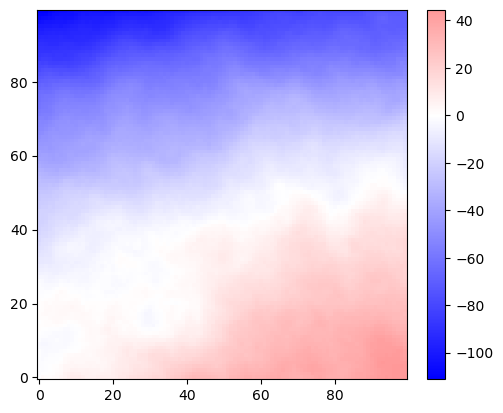

In [122]:
field = fbm_gen.sample()
fig, axes = plt.subplots()
cmap = bwr_cmap(field, vcenter=0)
im = axes.imshow(field, cmap=cmap, origin="lower")
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.show()

## Statistics test

### Generate an ensemble of fBm fields

In [96]:
# hurst = 0.05
# alpha = hurst * 2
# c = 1
# num_pt = 100
num_mc = 10000

x = np.linspace(0, num_pt-1, num_pt)
y = np.linspace(0, num_pt-1, num_pt)
x_normed = x / num_pt
y_normed = y / num_pt
X, Y = np.meshgrid(x, y)
var = 2*c*np.sqrt(X**2 + Y**2)**alpha

# Generator and sampling
fbm_gen = fBmGenerator(c=c, alpha=alpha, num_pt=num_pt, minpadding=minpadding)
orig_shape = tuple(len(p) for p in fbm_gen.pts)
fields = np.empty((num_mc, *orig_shape))

for i in range(num_mc):
    clear_output(wait=True)
    print_progress_bar(i, num_mc, prefix='Progress:', length=50)
    fields[i] = fbm_gen.sample()

Progress: |█████████████████████████████████████████████████-| 100.0% Complete                      


### Ensemble mean and variance

In [97]:
# ensemble mean at each gridpoint
mean_field = fields.mean(axis=0)

# ensemble variance at each gridpoint
var_field = fields.var(axis=0, ddof=1)

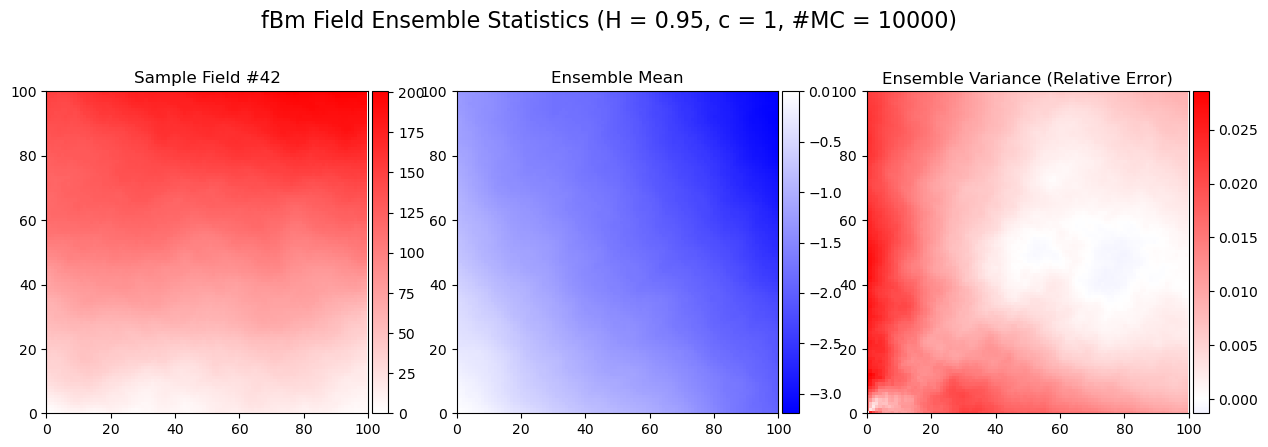

In [117]:
sample_idx = 42
sample_field = fields[sample_idx]

# Set up figure with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

# Plot 1: A sample realization
cmap = bwr_cmap(sample_field, vcenter=min(sample_field.flatten()))
im = axes[0].imshow(sample_field, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[0].set_xlim([x[0], x[-1]+1])
axes[0].set_ylim([y[0], y[-1]+1])
# axes[0].set_xlabel('x (pixels)')
# axes[0].set_ylabel('y (pixels)')
axes[0].set_title(f"Sample Field #{sample_idx}")
axes[0].set_box_aspect(1)

# Plot 2: Ensemble mean
cmap = bwr_cmap(mean_field, vcenter=max(mean_field.flatten()))
im = axes[1].imshow(mean_field, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[1].set_xlim([x[0], x[-1]+1])
axes[1].set_ylim([y[0], y[-1]+1])
# axes[1].set_xlabel('x (pixels)')
# axes[1].set_ylabel('y (pixels)')
axes[1].set_title("Ensemble Mean")
axes[1].set_box_aspect(1)

# Plot 3: Ensemble Standard Deviation
mask = var != 0
relative_err_var = np.zeros_like(var, dtype=float)
relative_err_var[mask] = var_field[mask] / var[mask] - 1
cmap = bwr_cmap(relative_err_var, vcenter=0)
im = axes[2].imshow(relative_err_var, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[2].set_xlim([x[0], x[-1]+1])
axes[2].set_ylim([y[0], y[-1]+1])
# axes[2].set_xlabel('x (pixels)')
# axes[2].set_ylabel('y (pixels)')
axes[2].set_title("Ensemble Variance (Relative Error)")
axes[2].set_box_aspect(1)

plt.suptitle(f"fBm Field Ensemble Statistics (H = {alpha/2}, c = {c}, #MC = {num_mc})", fontsize=16)
plt.show()

### Ensemble variogram

In [99]:
max_lag   = num_pt - 1
lags      = np.arange(1, max_lag + 1)
gamma_iso = np.zeros_like(lags, dtype=float)
gamma_std = np.zeros_like(lags, dtype=float)

for idx, h in enumerate(lags):
    # collect all increments at lag h
    diffs_all = []
    for d in range(fields.ndim - 1):  # skip ensemble axis at dim=0
        clear_output(wait=True)
        print_progress_bar(idx * (fields.ndim - 1) + d + 1, (fields.ndim - 1) * len(lags), prefix='Progress:', length=50)
        
        slicer1 = [slice(None)] * fields.ndim
        slicer2 = [slice(None)] * fields.ndim
        slicer1[d + 1] = slice(0, -h)
        slicer2[d + 1] = slice(h, None)

        diffs = fields[tuple(slicer1)] - fields[tuple(slicer2)]
        diffs_all.append(diffs.ravel())

    diffs_all = np.concatenate(diffs_all)
    N         = diffs_all.size

    # 1) compute unbiased variance of diffs:
    mean_diff = diffs_all.mean()
    sq_dev    = (diffs_all - mean_diff)**2
    var_diff  = sq_dev.sum() / (N - 1)         # = np.var(diffs_all, ddof=1)

    # 2) compute Var[Var(diffs)] = E[(sq_dev - var_diff)^2]
    var_var   = np.mean((sq_dev - var_diff)**2)

    # 3) semivariogram and its std:
    gamma_iso[idx] = var_diff / 2
    gamma_std[idx] = np.sqrt(var_var) / 2

Progress: |██████████████████████████████████████████████████| 100.0% Complete                      


In [100]:
# Compare empirical and theoretical variogram
gamma_theory = c * lags**alpha
rmse = np.sqrt(np.mean((gamma_theory - gamma_iso) ** 2))

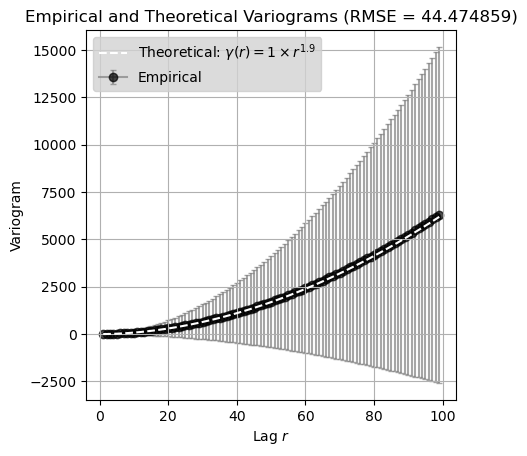

In [101]:
fig, ax = plt.subplots()
ax.errorbar(lags, gamma_iso, yerr=gamma_std, fmt='o-', color='gray', capsize=2, markersize=6, markeredgecolor='black', markerfacecolor='black', label=f'Empirical', alpha=0.7, zorder=1)
ax.plot(lags, gamma_theory, color='white', ls='--', label=fr"Theoretical: $\gamma(r) = {c} \times r^{{{alpha}}}$", zorder=10)
ax.set_xlabel("Lag $r$")
ax.set_ylabel("Variogram")
ax.set_title(f"Empirical and Theoretical Variograms (RMSE = {rmse:4f})")
ax.legend(facecolor='lightgray')
ax.grid(True, which="both")
ax.set_box_aspect(1)
plt.show()

### Ensemble histogram

In [102]:
# Compute histogram
counts, bin_edges = np.histogram(fields, bins=1000, density=True)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compare histogram with Gaussian fit
mean_ens_hist = fields.mean()
std_ens_hist = fields.std()
gaussian_fit = norm.pdf(bin_centers, loc=mean_ens_hist, scale=std_ens_hist)
z, P_z = calculate_theoretical_histogram(num_pt, hurst, sigma_sq=2*c)

# Compare histogram with pdf
interp_pdf = interp1d(z, P_z, kind='linear', bounds_error=False, fill_value=0.0)
pdf_theoretical_at_bins = interp_pdf(bin_centers)
rmse_pdf = np.sqrt(np.mean((counts - pdf_theoretical_at_bins)**2))

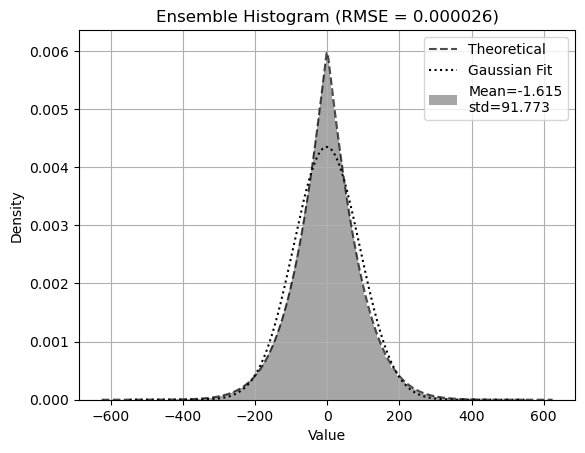

In [103]:
# Plot as bins using bar
plt.bar(bin_centers, counts, width=bin_width, align='center', alpha=0.7, color='gray', label=f'Mean={mean_ens_hist:.3f}\nstd={std_ens_hist:.3f}')
plt.plot(z, P_z, 'k--', alpha=0.7, label="Theoretical")
plt.plot(bin_centers, gaussian_fit, "k:", label='Gaussian Fit')
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(f"Ensemble Histogram (RMSE = {rmse_pdf:4f})")
plt.grid(True)
plt.legend()
plt.show()


### Save all plots as a pdf

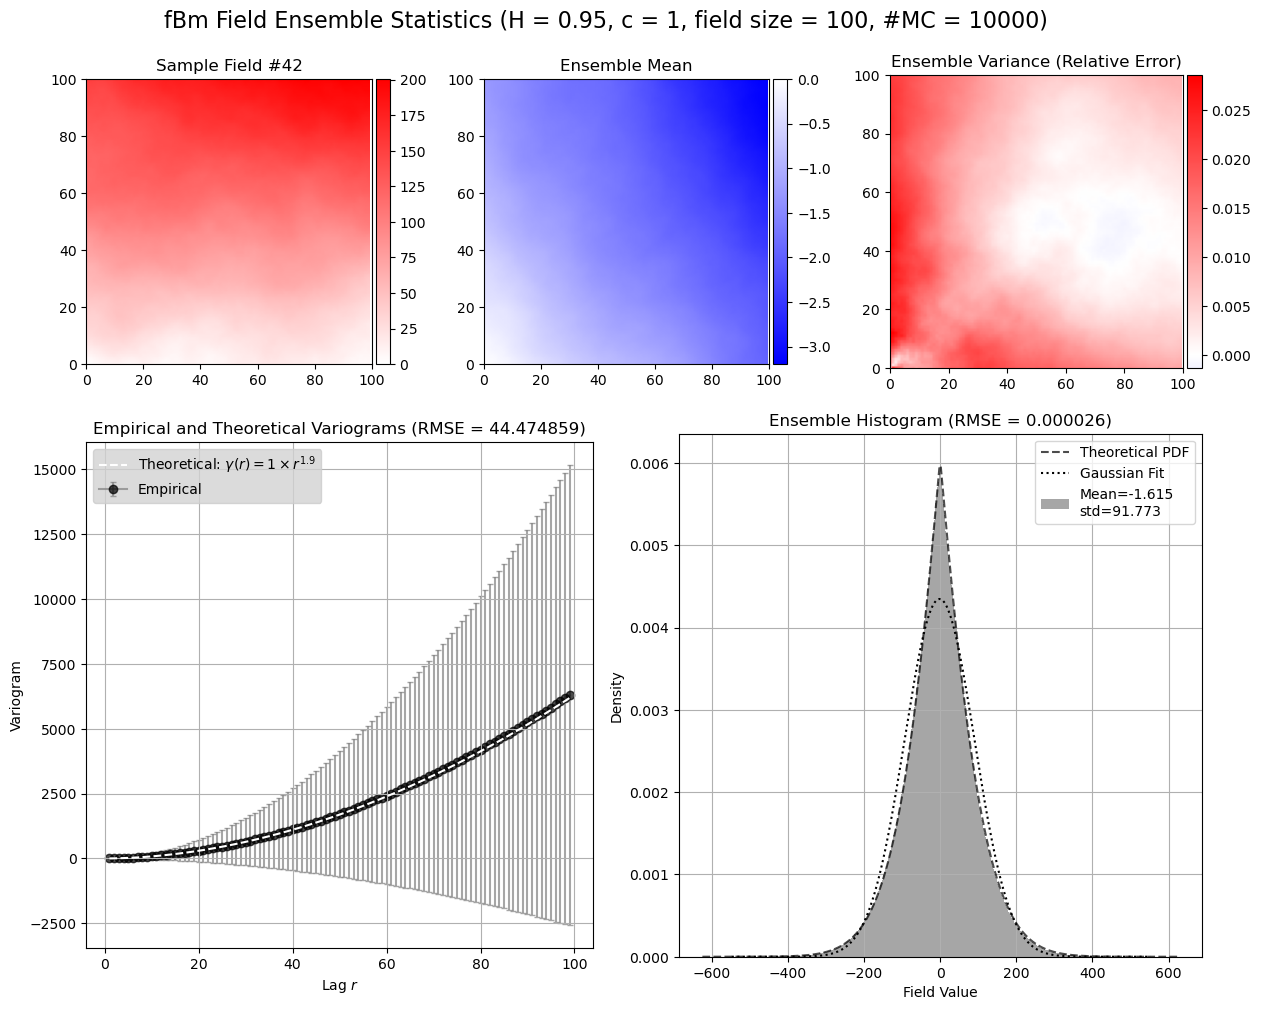

In [118]:
import matplotlib.pyplot as plt

# 1) Turn on constrained_layout to auto-adjust margins
fig = plt.figure(figsize=(12, 10), constrained_layout=True)

# 2) Make a 2×6 GridSpec, with row-heights 2:3 (in “units”)
gs = fig.add_gridspec(2, 6, height_ratios=[2, 3])

# 3) Build your axes into a flat list
axes = []

# Top row: 3 subplots, each spans 2 columns
for col in range(3):
    ax = fig.add_subplot(gs[0, col*2:(col+1)*2])
    axes.append(ax)

# Bottom row: 2 subplots, each spans 3 columns
axes.append(fig.add_subplot(gs[1, 0:3]))
axes.append(fig.add_subplot(gs[1, 3:6]))

# Plot 1: A sample realization
cmap = bwr_cmap(sample_field, vcenter=0)
im = axes[0].imshow(sample_field, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[0].set_xlim([x[0], x[-1]+1])
axes[0].set_ylim([y[0], y[-1]+1])
# axes[0].set_xlabel('x (pixels)')
# axes[0].set_ylabel('y (pixels)')
axes[0].set_title(f"Sample Field #{sample_idx}")
axes[0].set_box_aspect(1)

# Plot 2: Ensemble mean
cmap = bwr_cmap(mean_field, vcenter=0)
im = axes[1].imshow(mean_field, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[1].set_xlim([x[0], x[-1]+1])
axes[1].set_ylim([y[0], y[-1]+1])
# axes[1].set_xlabel('x (pixels)')
# axes[1].set_ylabel('y (pixels)')
axes[1].set_title("Ensemble Mean")
axes[1].set_box_aspect(1)

# Plot 3: Ensemble Standard Deviation
mask = var != 0
relative_err_var = np.zeros_like(var, dtype=float)
relative_err_var[mask] = var_field[mask] / var[mask] - 1
cmap = bwr_cmap(relative_err_var, vcenter=0)
im = axes[2].imshow(relative_err_var, cmap=cmap, origin="lower")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(im, cax=cax)
axes[2].set_xlim([x[0], x[-1]+1])
axes[2].set_ylim([y[0], y[-1]+1])
# axes[2].set_xlabel('x (pixels)')
# axes[2].set_ylabel('y (pixels)')
axes[2].set_title("Ensemble Variance (Relative Error)")
axes[2].set_box_aspect(1)

# Plot 4: Ensemble Variogram
axes[3].errorbar(lags, gamma_iso, yerr=gamma_std, fmt='o-', color='gray', capsize=2, markersize=6, markeredgecolor='black', markerfacecolor='black', label=f'Empirical', alpha=0.7, zorder=1)
axes[3].plot(lags, gamma_theory, color='white', ls='--', label=fr"Theoretical: $\gamma(r) = {c} \times r^{{{alpha}}}$", zorder=10)
axes[3].set_xlabel("Lag $r$")
axes[3].set_ylabel("Variogram")
axes[3].set_title(f"Empirical and Theoretical Variograms (RMSE = {rmse:4f})")
axes[3].legend(facecolor='lightgray')
axes[3].grid(True, which="both")
axes[3].set_box_aspect(1)

# Plot 4: Ensemble Histogram
axes[4].bar(bin_centers, counts, width=bin_width, align='center', alpha=0.7, color='gray', label=f'Mean={mean_ens_hist:.3f}\nstd={std_ens_hist:.3f}')
axes[4].plot(z, P_z, 'k--', alpha=0.7, label="Theoretical PDF")
axes[4].plot(bin_centers, gaussian_fit, "k:", label='Gaussian Fit')
axes[4].set_xlabel("Field Value")
axes[4].set_ylabel("Density")
axes[4].set_title(f"Ensemble Histogram (RMSE = {rmse_pdf:4f})")
axes[4].grid(True)
axes[4].legend()
axes[4].set_box_aspect(1)

plt.suptitle(f"fBm Field Ensemble Statistics (H = {alpha/2}, c = {c}, field size = {num_pt}, #MC = {num_mc})", fontsize=16)
plt.savefig(f'stats_fbm_hurst{hurst}_c{c}_size{num_pt}_mc{num_mc}.png', bbox_inches='tight')
plt.show()
